In [1]:
from collections import Counter, defaultdict, deque
from functools import partial
from itertools import chain, cycle, product

import numpy as np

In [2]:
recipes = [
    {"A": 8, "B": 4, "C": 4, "D": 8, "E": 10, "F": 16},
    {"A": 10, "B": 10, "C": 6, "D": 4},
    {"A": 3, "B": 3, "C": 4, "D": 3, "E": 3, "F": 2},
]
batch_sizes = [25, 50, 100]
sample_size = 10000
lane_lock = 25

In [3]:
def generate_sequential_batches(batch_size, recipe, sample_size):
    products = list(recipe.keys())
    totals = list(recipe.values())
    num_of_batches = np.ceil(sample_size / batch_size).astype(int)

    counts = dict(sorted(zip(products, totals), key=lambda x: x[1], reverse=True))

    pattern = []
    while 0 < sum(counts.values()):
        for product in counts.keys():
            if 0 < counts[product]:
                pattern.append(product)
                counts[product] -= 1

    out = []
    for index, product in zip(range(num_of_batches), cycle(pattern)):
        out.append(product)

    return out

In [4]:
def generate_random_batches(batch_size, recipe, sample_size):
    products = list(recipe.keys())
    totals = list(recipe.values())
    num_of_batches = np.ceil(sample_size / batch_size).astype(int)
    return np.random.choice(
        products,
        size=num_of_batches,
        p=[t / sum(totals) for t in totals],
    ).tolist()

In [5]:
def generate_random_products(recipe, sample_size):
    products = list(recipe.keys())
    return np.random.choice(
        products,
        size=sample_size,
        p=[t / sum(recipe.values()) for t in recipe.values()],
    ).tolist()

In [6]:
# # consider lane with lowest index (index := lane number)
# def no_priority(lane_tuple, product=None):

#     if product is None:
#         raise RuntimeError("No product set")

#     return lane_tuple[0]

# # consider lane with largest total number of products
def sum_of_product_priority(lane_tuple, product=None, boxes=None):

    if product is None:
        raise RuntimeError("No product set")

    return (sum(lane_tuple[1].values()), -boxes[lane_tuple[0]])


# # consider lane with largest product count e.g., largest number of As
# def product_count_priority(lane_tuple, product=None):

#     if product is None:
#         raise RuntimeError("No product set")

#     return lane_tuple[1][product]

# # consider largest product count first, then largest sum of all products second
# def double_priority(lane_tuple, product=None):

#     if product is None:
#         raise RuntimeError("No product set")

#     return (lane_tuple[1][product], sum(lane_tuple[1].values()))


# lane priority
def product_count_lane_utilization_priority(lane_tuple, product=None, boxes=None):

    if product is None or boxes is None:
        raise RuntimeError("Please provide product and lane state")

    # negative sign since we prioritize lanes with lowest utilization
    return (lane_tuple[1][product], -boxes[lane_tuple[0]])


def random_priority(lane_tuple, product=None, boxes=None):

    if product is None or boxes is None:
        raise RuntimeError("Please provide product and lane state")

    return np.random.rand()

In [7]:
# choose priority
priority_of_lanes = sum_of_product_priority

In [8]:
sequences = {}

for i, batch_size in product(range(len(recipes)), batch_sizes):
    sequences[(i, "random_batches", batch_size)] = generate_random_batches(
        batch_size, recipes[i], sample_size
    )

for i, batch_size in product(range(len(recipes)), batch_sizes):
    sequences[(i, "sequential_batches", batch_size)] = generate_sequential_batches(
        batch_size, recipes[i], sample_size
    )

for i, batch_size in product(range(len(recipes)), batch_sizes):
    sequences[(i, "smart_batches", batch_size)] = None

for i, recipe in enumerate(recipes):
    sequences[(i, "random_products", None)] = generate_random_products(
        recipe, sample_size
    )

In [9]:
def queue_priority(product, lanes=None, recipe=None, batch_size=None):
    if lanes is None or recipe is None or batch_size is None:
        raise RuntimeError("Lanes must be supplied")

    missing = 0
    for lane in lanes.values():
        if lane["lock"] == 0:
            missing += recipe[product] - lane[product]

    # fits = int(batch_size <= missing)
    return missing

In [10]:
def simulate(
    sample_size,
    num_of_lanes,
    sequence_type,
    recipe_index,
    recipe,
    lane_lock,
    priority,
    batch_size=None,
    reverse=True,
):
    products = list(recipe.keys())
    totals = list(recipe.values())
    batch_order = []
    lanes = {i: {p: 0 for p in products + ["lock"]} for i in range(num_of_lanes)}
    boxes_per_lane = {i: 0 for i in range(num_of_lanes)}
    boxes_per_frame = {i: [] for i in range(num_of_lanes)}
    recirculation = []

    # init products
    product_queue = deque()

    if sequence_type in ["random_batches", "sequential_batches"]:

        if batch_size is None:
            raise RuntimeError(f"batch_size must be specified")

        batches_queue = deque(sequences[(recipe_index, sequence_type, batch_size)])
        next_batch = batches_queue.popleft()
        batch_order.append(next_batch)

        product_queue.extend([next_batch] * batch_size)

    elif sequence_type == "random_products":

        product_queue.extend(sequences[(recipe_index, sequence_type, None)])

    elif sequence_type == "smart_batches":

        if batch_size is None:
            raise RuntimeError(f"batch_size must be specified")

        next_batch = max(
            products,
            key=partial(
                queue_priority, lanes=lanes, recipe=recipe, batch_size=batch_size
            ),
        )
        batch_order.append(next_batch)

        product_queue.extend([next_batch] * batch_size)

    else:
        raise RuntimeError(f"sequence_type {sequence_type} if unknown!")

    product_counter = 0
    while product_counter < sample_size:

        product = product_queue.popleft()
        consumed = False
        for i, lane in sorted(
            lanes.items(),
            key=partial(priority, product=product, boxes=boxes_per_lane),
            reverse=reverse,
        ):

            # Lane is available to accept products
            lane_is_available = lane["lock"] == 0

            # Lane has space to accept product
            product_fits = lane[product] < recipe[product]

            # Complete cases for 3 binary variables
            if not consumed and lane_is_available and product_fits:
                lane[product] += 1
                consumed = True

            elif not consumed and lane_is_available and not product_fits:
                continue

            elif not consumed and not lane_is_available and product_fits:
                lane["lock"] -= 1

            elif not consumed and not lane_is_available and not product_fits:
                lane["lock"] -= 1

            elif consumed and lane_is_available and product_fits:
                continue

            elif consumed and lane_is_available and not product_fits:
                continue

            elif consumed and not lane_is_available and product_fits:
                lane["lock"] -= 1

            elif consumed and not lane_is_available and not product_fits:
                lane["lock"] -= 1

        # recirculation un-consumed products
        if not consumed:
            recirculation.append(product)

        # Lane is ready to be boxed
        for j in lanes:
            boxes_per_frame[j].append(0)
            if all(lanes[j][p] == recipe[p] for p in products):
                lanes[j] = {p: 0 for p in products + ["lock"]}
                lanes[j]["lock"] = lane_lock
                boxes_per_lane[j] += 1
                boxes_per_frame[j][product_counter] = 1

        # continue onto the next product
        product_counter += 1

        # check if the queue is empty
        if (
            len(product_queue) == 0
            and sequence_type == "smart_batches"
            and product_counter < sample_size
        ):
            next_batch = max(
                products,
                key=partial(
                    queue_priority, lanes=lanes, recipe=recipe, batch_size=batch_size
                ),
            )
            batch_order.append(next_batch)
            product_queue.extend([next_batch] * batch_size)

        elif (
            len(product_queue) == 0
            and sequence_type in ["random_batches", "sequential_batches"]
            and product_counter < sample_size
        ):
            next_batch = batches_queue.popleft()
            batch_order.append(next_batch)
            product_queue.extend([next_batch] * batch_size)

    return {
        "recirculation": len(recirculation),
        "sample_size": sample_size,
        "box_products": sum(recipe.values()) * sum(boxes_per_lane.values()),
        "unbox_products": sample_size
        - len(recirculation)
        - sum(recipe.values()) * sum(boxes_per_lane.values()),
        "boxes_per_lane": boxes_per_lane,
        "boxes": sum(boxes_per_lane.values()),
        "boxes_per_frame": boxes_per_frame,
        "batch_order": batch_order,
    }

In [11]:
out = simulate(
    sample_size, 5, "random_products", 0, recipes[0], lane_lock, priority_of_lanes
)
out.pop("boxes_per_frame")
out

{'recirculation': 521,
 'sample_size': 10000,
 'box_products': 9400,
 'unbox_products': 79,
 'boxes_per_lane': {0: 38, 1: 38, 2: 38, 3: 37, 4: 37},
 'boxes': 188,
 'batch_order': []}

In [12]:
out = simulate(sample_size, 5, "random_batches", 0, recipes[0], lane_lock, priority_of_lanes, batch_size=50)
out.pop("boxes_per_frame")
batch_counts = Counter(out.pop("batch_order"))
print({k: round(value / min(batch_counts.values()), 2) for k, value in sorted(batch_counts.items())})
print({k: round(value / min(recipes[0].values()), 2) for k, value in sorted(recipes[0].items())})
out

{'A': 1.93, 'B': 1.0, 'C': 1.43, 'D': 2.07, 'E': 2.79, 'F': 5.07}
{'A': 2.0, 'B': 1.0, 'C': 1.0, 'D': 2.0, 'E': 2.5, 'F': 4.0}


{'recirculation': 7560,
 'sample_size': 10000,
 'box_products': 2250,
 'unbox_products': 190,
 'boxes_per_lane': {0: 9, 1: 9, 2: 9, 3: 9, 4: 9},
 'boxes': 45}

In [13]:
out = simulate(sample_size, 5, "sequential_batches", 0, recipes[0], lane_lock, priority_of_lanes, batch_size=50)
out.pop("boxes_per_frame")
batch_counts = Counter(out.pop("batch_order"))
print({k: round(value / min(batch_counts.values()), 2) for k, value in sorted(batch_counts.items())})
print({k: round(value / min(recipes[0].values()), 2) for k, value in sorted(recipes[0].items())})
out

{'A': 2.0, 'B': 1.0, 'C': 1.0, 'D': 2.0, 'E': 2.5, 'F': 4.0}
{'A': 2.0, 'B': 1.0, 'C': 1.0, 'D': 2.0, 'E': 2.5, 'F': 4.0}


{'recirculation': 6090,
 'sample_size': 10000,
 'box_products': 3700,
 'unbox_products': 210,
 'boxes_per_lane': {0: 15, 1: 15, 2: 15, 3: 15, 4: 14},
 'boxes': 74}

In [14]:
out = simulate(sample_size, 5, "smart_batches", 0, recipes[0], lane_lock, priority_of_lanes, batch_size=50)
out.pop("boxes_per_frame")
batch_counts = Counter(out.pop("batch_order"))
print({k: round(value / min(batch_counts.values()), 2) for k, value in sorted(batch_counts.items())})
print({k: round(value / min(recipes[0].values()), 2) for k, value in sorted(recipes[0].items())})
out

{'A': 1.94, 'B': 1.0, 'C': 1.0, 'D': 1.94, 'E': 1.94, 'F': 3.94}
{'A': 2.0, 'B': 1.0, 'C': 1.0, 'D': 2.0, 'E': 2.5, 'F': 4.0}


{'recirculation': 1680,
 'sample_size': 10000,
 'box_products': 8250,
 'unbox_products': 70,
 'boxes_per_lane': {0: 33, 1: 33, 2: 33, 3: 33, 4: 33},
 'boxes': 165}

In [15]:
def get_the_ys(
    xx, sequence_type, recipe_index, recipe, batch_size, priority=priority_of_lanes
):
    yy = []
    for x in xx:
        data = simulate(
            sample_size,
            x,
            sequence_type,
            recipe_index,
            recipe,
            lane_lock,
            priority,
            batch_size=batch_size,
        )
#         yy.append((data["box_products"] + data["unbox_products"]) / data["sample_size"])
        yy.append(data["box_products"] / data["sample_size"])

    return yy

In [16]:
def recipe_inefficiency(recipe):
    totals = list(recipe.values())
    consumption = np.array(totals) / np.min(totals)
    production = np.ceil(np.array(totals) / np.min(totals))
    return np.sum(production - consumption) / np.sum(production)

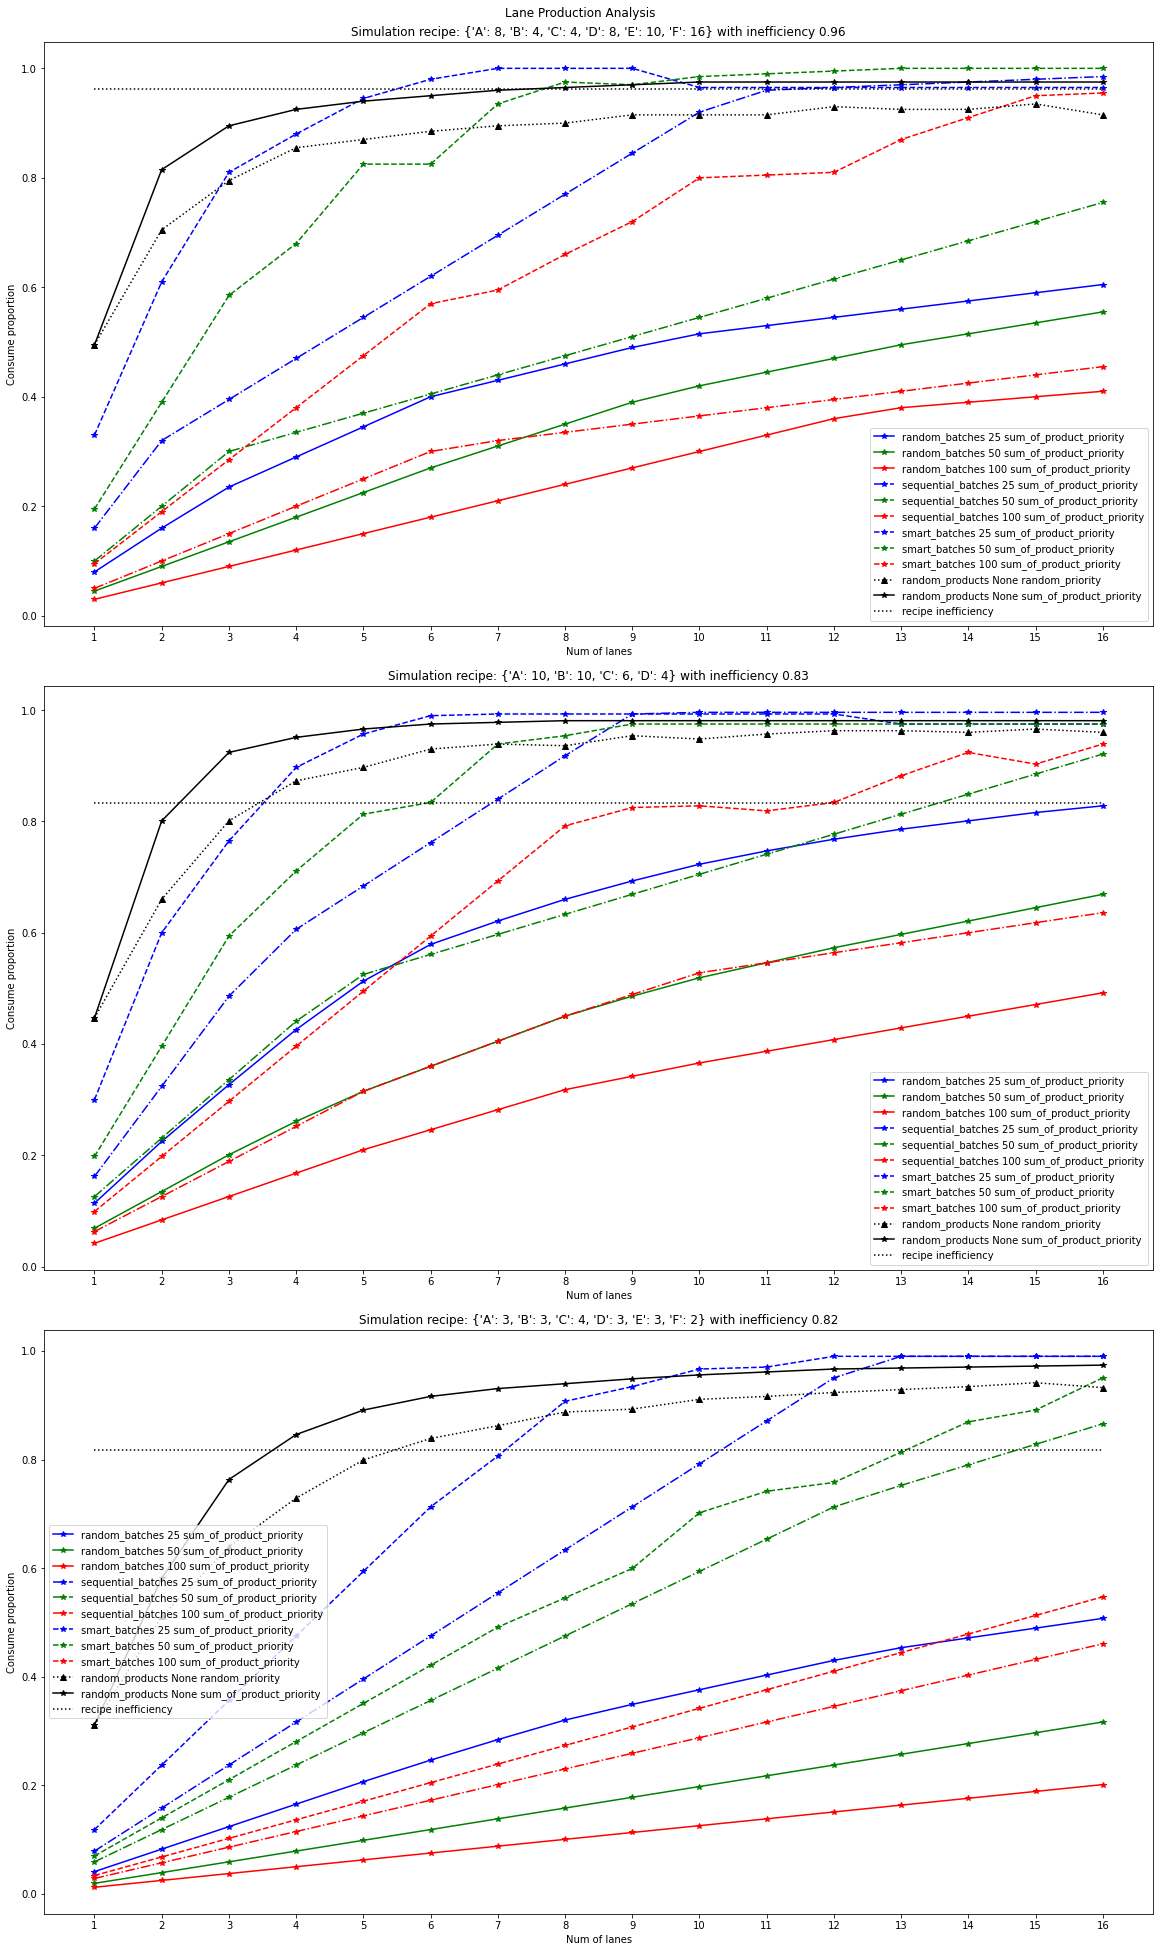

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, axs = plt.subplots(len(recipes), figsize=(16, 9*len(recipes)), constrained_layout=True)

fig.suptitle("Lane Production Analysis")
 
color_map = defaultdict(lambda: "k")
for batch_size, color in zip(batch_sizes, mcolors.BASE_COLORS.keys()):
    color_map[batch_size] = color

line_type_map = defaultdict(lambda: "-")
line_type_map["smart_batches"] = "--"
line_type_map["sequential_batches"] = "-."

xx = list(range(1, 17))

for (recipe_index, sequence_type, batch_size) in sequences.keys():
    color = color_map[batch_size]
    line_type = line_type_map[sequence_type]

    if sequence_type in ["random_products"]:
        yy = get_the_ys(xx, sequence_type, recipe_index, recipes[recipe_index], batch_size, random_priority)
        axs[recipe_index].plot(xx, yy, f":{color}", marker="^", label=f"{sequence_type} {batch_size} random_priority")
        
    if sequence_type in ["random_products", "random_batches", "smart_batches", "sequential_batches"]:
        yy = get_the_ys(xx, sequence_type, recipe_index, recipes[recipe_index], batch_size, sum_of_product_priority)
        axs[recipe_index].plot(xx, yy, f"{line_type}{color}", marker="*", label=f"{sequence_type} {batch_size} sum_of_product_priority")

for recipe_index, recipe in enumerate(recipes):
    zz = np.ones(len(xx)) * (1-recipe_inefficiency(recipe))
    axs[recipe_index].plot(xx, zz, f":k", label=f"recipe inefficiency")
    axs[recipe_index].set_xticks(xx)
    axs[recipe_index].legend()
    axs[recipe_index].set_title(f"Simulation recipe: {recipe} with inefficiency {round(zz[0], 2)}")
    axs[recipe_index].set_xlabel("Num of lanes")
    axs[recipe_index].set_ylabel("Consume proportion")

plt.show()

In [18]:
# priority_of_lanes = random_priority
priority_of_lanes = sum_of_product_priority
# priority_of_lanes = product_count_lane_utilization_priority
batch_size = 50
frame_per_min = 250
num_of_lanes = 8
recipe_index = 0

In [19]:
optimal_boxes_per_min = frame_per_min / sum(recipes[recipe_index].values())
optimal_boxes_per_min_per_lane = optimal_boxes_per_min / num_of_lanes
optimal_boxes_per_min, optimal_boxes_per_min_per_lane

(5.0, 0.625)

In [20]:
# plt.figure(figsize=(16, 6))

# for num_of_lane in range(1, 10):
#     data = simulate(sample_size, num_of_lane, "random_products", 0, recipes[0], lane_lock, priority_of_lanes)
#     x = np.array(list(data["boxes_per_frame"].values())).sum(axis=0)
#     arrays = np.array_split(x, range(frame_per_min, len(x), frame_per_min))
#     y = [a.sum() for a in arrays]
#     plt.plot([0] + y, label=f"Lanes {num_of_lane}")

# plt.legend()

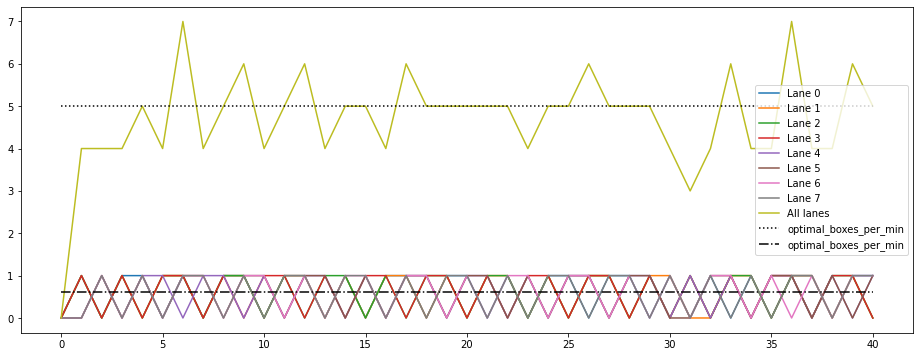

In [21]:
plt.figure(figsize=(16, 6))

data = simulate(sample_size, num_of_lanes, "random_products", recipe_index, recipes[recipe_index], lane_lock, priority_of_lanes)

for lane, production in data["boxes_per_frame"].items():
    arrays = np.array_split(production, range(frame_per_min, len(production), frame_per_min))
    y = [a.sum() for a in arrays]
    plt.plot([0] + y, label=f"Lane {lane}")

# combine all lanes
x = np.array(list(data["boxes_per_frame"].values())).sum(axis=0)
arrays = np.array_split(x, range(frame_per_min, len(x), frame_per_min))
y = [a.sum() for a in arrays]
plt.plot([0] + y, label=f"All lanes")    

# optimality lines
plt.plot([optimal_boxes_per_min] * (len(y) + 1), f":k", label=f"optimal_boxes_per_min")    
plt.plot([optimal_boxes_per_min_per_lane] * (len(y) + 1), f"-.k", label=f"optimal_boxes_per_min")    

plt.legend()

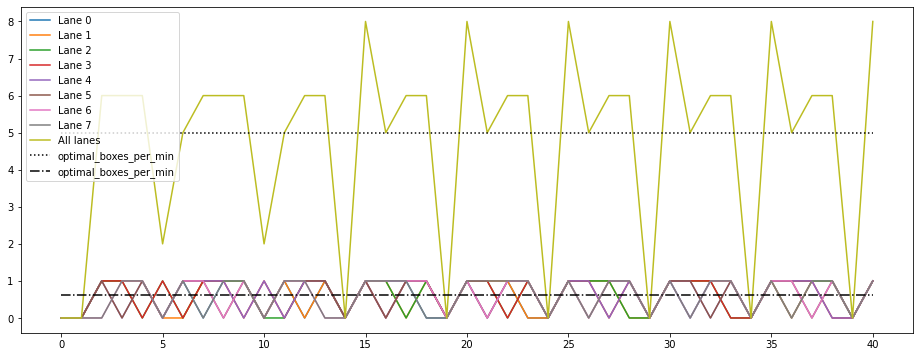

In [22]:
plt.figure(figsize=(16, 6))

data = simulate(sample_size, num_of_lanes, "smart_batches", recipe_index, recipes[recipe_index], lane_lock, priority_of_lanes, batch_size=batch_size)    
    
for lane, production in data["boxes_per_frame"].items():
    arrays = np.array_split(production, range(frame_per_min, len(production), frame_per_min))
    y = [a.sum() for a in arrays]
    plt.plot([0] + y, label=f"Lane {lane}")

# combine all lanes
x = np.array(list(data["boxes_per_frame"].values())).sum(axis=0)
arrays = np.array_split(x, range(frame_per_min, len(x), frame_per_min))
y = [a.sum() for a in arrays]
plt.plot([0] + y, label=f"All lanes")    

# optimality lines
plt.plot([optimal_boxes_per_min] * (len(y) + 1), f":k", label=f"optimal_boxes_per_min")    
plt.plot([optimal_boxes_per_min_per_lane] * (len(y) + 1), f"-.k", label=f"optimal_boxes_per_min")    

plt.legend()

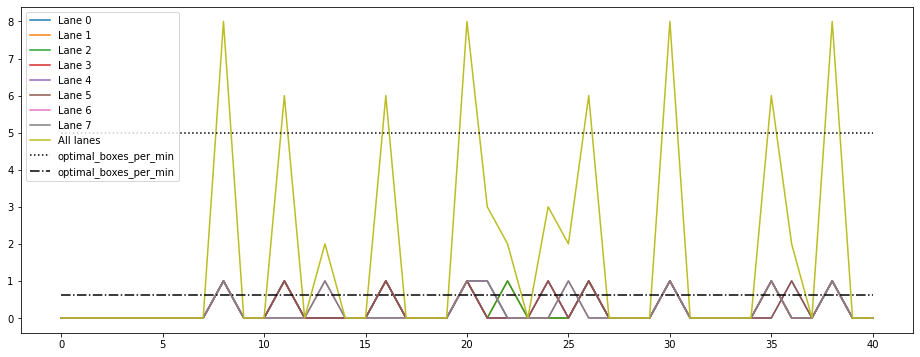

In [23]:
plt.figure(figsize=(16, 6))

data = simulate(sample_size, num_of_lanes, "random_batches", recipe_index, recipes[recipe_index], lane_lock, priority_of_lanes, batch_size=batch_size)

for lane, production in data["boxes_per_frame"].items():
    arrays = np.array_split(production, range(frame_per_min, len(production), frame_per_min))
    y = [a.sum() for a in arrays]
    plt.plot([0] + y, label=f"Lane {lane}")

# combine all lanes
x = np.array(list(data["boxes_per_frame"].values())).sum(axis=0)
arrays = np.array_split(x, range(frame_per_min, len(x), frame_per_min))
y = [a.sum() for a in arrays]
plt.plot([0] + y, label=f"All lanes")    

# optimality lines
plt.plot([optimal_boxes_per_min] * (len(y) + 1), f":k", label=f"optimal_boxes_per_min")    
plt.plot([optimal_boxes_per_min_per_lane] * (len(y) + 1), f"-.k", label=f"optimal_boxes_per_min")    

plt.legend()

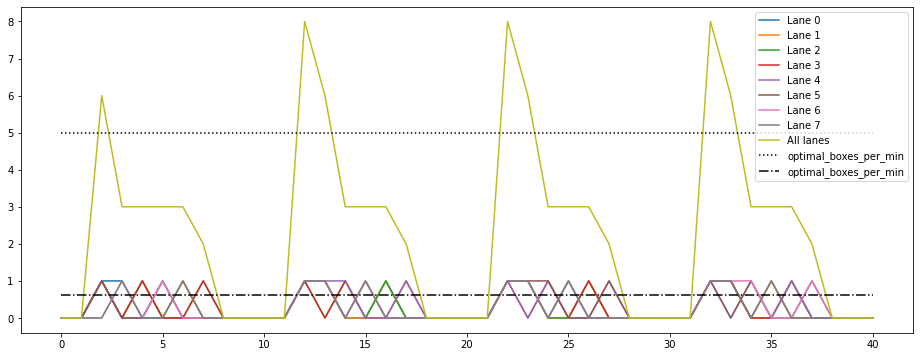

In [24]:
plt.figure(figsize=(16, 6))

data = simulate(sample_size, num_of_lanes, "sequential_batches", recipe_index, recipes[recipe_index], lane_lock, priority_of_lanes, batch_size=batch_size)

for lane, production in data["boxes_per_frame"].items():
    arrays = np.array_split(production, range(frame_per_min, len(production), frame_per_min))
    y = [a.sum() for a in arrays]
    plt.plot([0] + y, label=f"Lane {lane}")

# combine all lanes
x = np.array(list(data["boxes_per_frame"].values())).sum(axis=0)
arrays = np.array_split(x, range(frame_per_min, len(x), frame_per_min))
y = [a.sum() for a in arrays]
plt.plot([0] + y, label=f"All lanes")    

# optimality lines
plt.plot([optimal_boxes_per_min] * (len(y) + 1), f":k", label=f"optimal_boxes_per_min")    
plt.plot([optimal_boxes_per_min_per_lane] * (len(y) + 1), f"-.k", label=f"optimal_boxes_per_min")    

plt.legend()

TODO:

    * Shuffle every few batches
    * Implement hopper (what capabilities does the hopper have)
    * Smart batches (might not be how it works IRL)
        * First send a few batches
        * Then trigger a call back
        * Model delay between lane states and batch infeed source

In [25]:
import string


def generate_random_recipes(num_of_recipes, min_num_of_products, max_num_of_products, lower, upper):
    recipes = []
    for r in range(num_of_recipes):
        recipe = {}

        for product in string.ascii_uppercase[
            : np.random.randint(min_num_of_products, high=max_num_of_products)
        ]:
            recipe[product] = np.random.randint(lower, high=upper)

        recipes.append(recipe)

    return recipes

In [26]:
recipes = generate_random_recipes(150, 3, 6, 2, 16)
recipes

[{'A': 7, 'B': 8, 'C': 2, 'D': 13, 'E': 9},
 {'A': 12, 'B': 4, 'C': 11},
 {'A': 11, 'B': 5, 'C': 8, 'D': 5},
 {'A': 3, 'B': 15, 'C': 7},
 {'A': 5, 'B': 14, 'C': 6, 'D': 6, 'E': 13},
 {'A': 10, 'B': 8, 'C': 8, 'D': 9},
 {'A': 15, 'B': 4, 'C': 14, 'D': 13},
 {'A': 9, 'B': 5, 'C': 2, 'D': 7},
 {'A': 13, 'B': 9, 'C': 6},
 {'A': 15, 'B': 15, 'C': 7, 'D': 4, 'E': 13},
 {'A': 3, 'B': 15, 'C': 15},
 {'A': 6, 'B': 11, 'C': 15, 'D': 15, 'E': 3},
 {'A': 3, 'B': 12, 'C': 2},
 {'A': 13, 'B': 7, 'C': 10, 'D': 8},
 {'A': 13, 'B': 3, 'C': 12, 'D': 12, 'E': 4},
 {'A': 10, 'B': 14, 'C': 5, 'D': 9, 'E': 4},
 {'A': 5, 'B': 10, 'C': 5},
 {'A': 3, 'B': 5, 'C': 2, 'D': 10, 'E': 4},
 {'A': 5, 'B': 15, 'C': 9},
 {'A': 3, 'B': 5, 'C': 9, 'D': 5},
 {'A': 2, 'B': 11, 'C': 4},
 {'A': 8, 'B': 2, 'C': 13, 'D': 3, 'E': 11},
 {'A': 10, 'B': 6, 'C': 8},
 {'A': 9, 'B': 8, 'C': 12},
 {'A': 2, 'B': 12, 'C': 9},
 {'A': 6, 'B': 12, 'C': 8, 'D': 11, 'E': 14},
 {'A': 13, 'B': 4, 'C': 7, 'D': 14},
 {'A': 3, 'B': 14, 'C': 14, '

In [27]:
sequences = {}

for i, batch_size in product(range(len(recipes)), batch_sizes):
    sequences[(i, "random_batches", batch_size)] = generate_random_batches(
        batch_size, recipes[i], sample_size
    )

for i, batch_size in product(range(len(recipes)), batch_sizes):
    sequences[(i, "sequential_batches", batch_size)] = generate_sequential_batches(
        batch_size, recipes[i], sample_size
    )

for i, batch_size in product(range(len(recipes)), batch_sizes):
    sequences[(i, "smart_batches", batch_size)] = None

for i, recipe in enumerate(recipes):
    sequences[(i, "random_products", None)] = generate_random_products(
        recipe, sample_size
    )

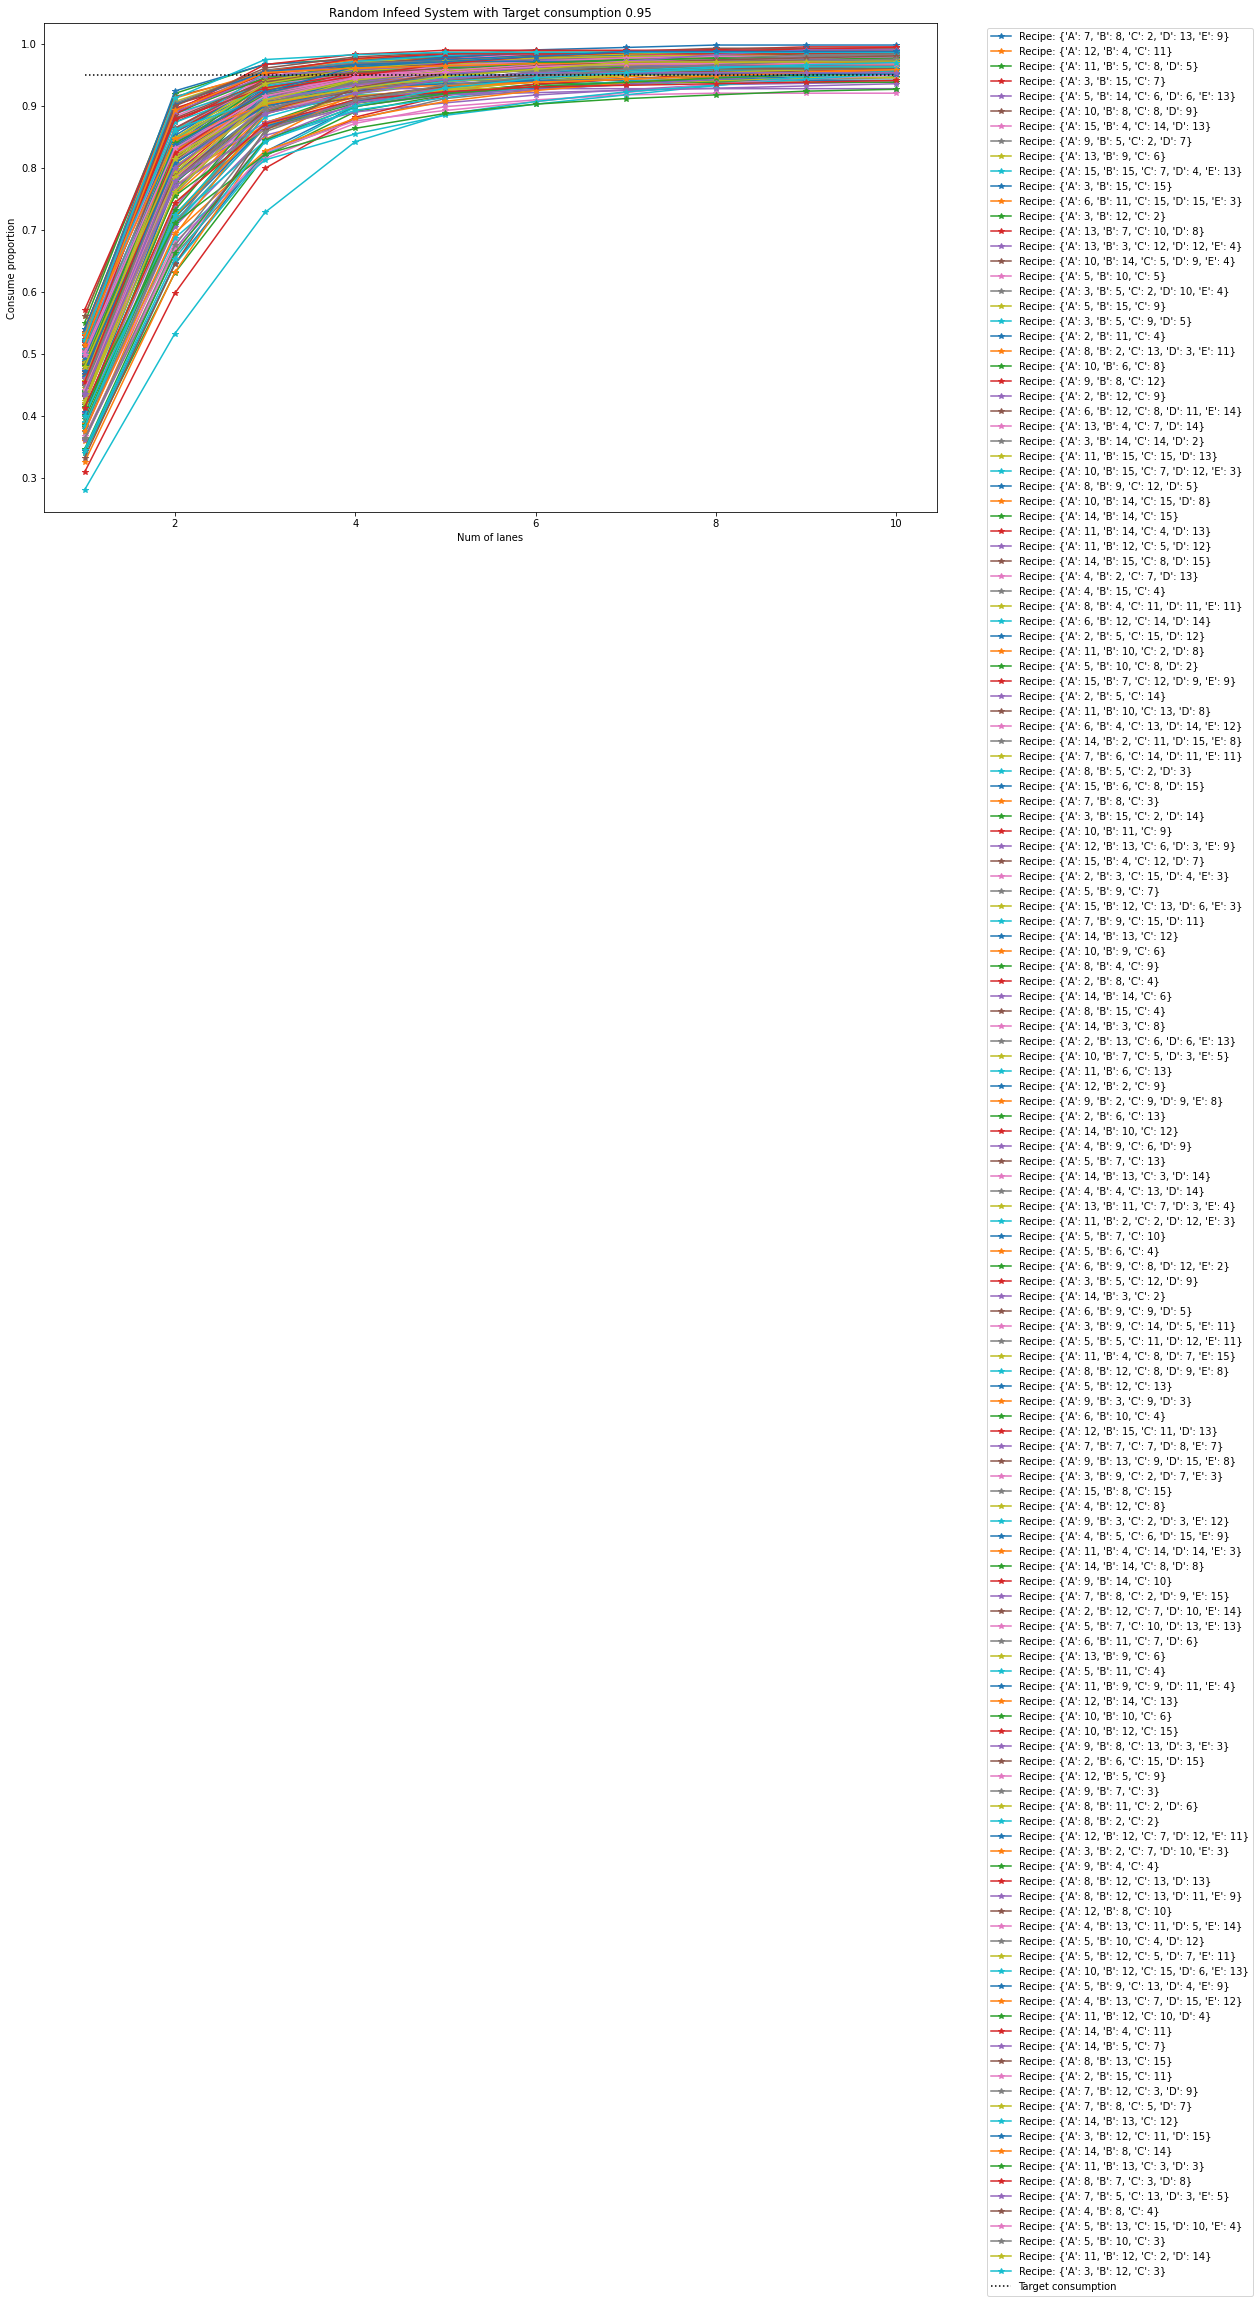

In [28]:
# fig, axs = plt.subplots(len(recipes), figsize=(16, 9*len(recipes)), constrained_layout=True)
plt.figure(figsize=(16, 9))


# fig.suptitle("Lane Production Analysis")
 
color_map = defaultdict(lambda: "k")
for batch_size, color in zip(batch_sizes, mcolors.BASE_COLORS.keys()):
    color_map[batch_size] = color

line_type_map = defaultdict(lambda: "-")
line_type_map["smart_batches"] = "--"
line_type_map["sequential_batches"] = "-."

xx = list(range(1, 11))
arrays = []
for recipe_index, recipe in enumerate(recipes):
    
    color = color_map[batch_size]
    line_type = line_type_map[sequence_type]
    
    yy = get_the_ys(xx, "random_products", recipe_index, recipes[recipe_index], None, sum_of_product_priority)
    arrays.append(yy)
    plt.plot(xx, yy, marker="*", label=f"Recipe: {recipe}")

target_consumption = 0.95
zz = np.ones(len(xx)) * target_consumption
plt.plot(xx, zz, f":k", label=f"Target consumption")
# plt.set_xticks(xx)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title(f"Random Infeed System with Target consumption {target_consumption}")
plt.xlabel("Num of lanes")
plt.ylabel("Consume proportion")

plt.show()

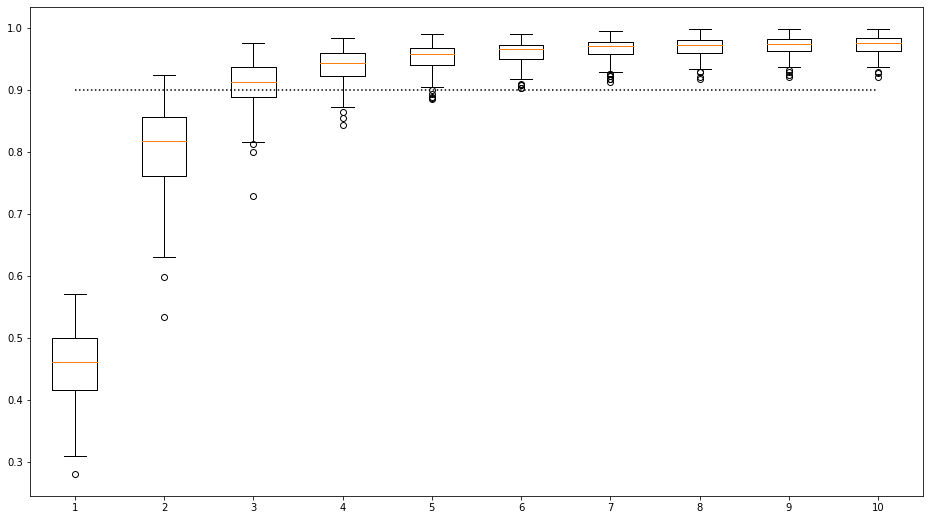

In [33]:
plt.figure(figsize=(16, 9))

plt.boxplot(np.array(arrays))

target_consumption = 0.90
zz = np.ones(len(xx)) * target_consumption
plt.plot(xx, zz, ':k')

plt.show()